In [1]:
from math import exp
from statistics import fmean, pstdev
from random import random
from copy import deepcopy
from tqdm import tqdm, trange
from matplotlib import pyplot as plt

## read data

In [2]:
def normalization_factors(xss):
    return [(fmean(xs), pstdev(xs)) for xs in zip(*xss)]

def normalized_input(xss, stats):
    return [[(x - m) / s for x, (m, s) in zip(xs, stats)] for xs in xss]

In [3]:
def read_train(filename):
    with open(filename) as f:
        data = f.readlines()
    
    # read column headers
    line = [item.strip() for item in data[0].split(',')]
    attr_vars = line[:-1]
    class_var = line[-1]
    
    class_count = 0
    class_name_to_idx = {}
    class_idx_to_name = []
    
    x_train = []
    y_train = []

    # read train data
    for line in data[1:]:
        line = [item.strip() for item in line.split(',')]
        c = line[-1]
        if c not in class_name_to_idx:
            class_name_to_idx[c] = class_count
            class_idx_to_name.append(c)
            class_count += 1
        x_train.append([float(val) for val in line[:-1]])
        y_train.append(class_name_to_idx[c])
        
    stats = normalization_factors(x_train)
    x_train = normalized_input(x_train, stats)
    
    return attr_vars, class_var, class_name_to_idx, class_idx_to_name, list(zip(x_train, y_train)), stats, len(x_train)

In [4]:
def read_test(filename, stats):
    with open(filename) as f:
        data = f.readlines()
    
    x_test = []
    for line in data[1:]:
        line = [item.strip() for item in line.split(',')]
        x_test.append([float(val) for val in line])
    
    return normalized_input(x_test, stats)

## activation and loss functions

In [5]:
sigmoid = lambda xs: [1 / (1 + exp(-x)) for x in xs]
sigmoid_prime = lambda x: 1 / (1 + exp(-x)) * (1 - 1 / (1 + exp(-x)))

relu = lambda xs: [x if x > 0 else 0 for x in xs]
relu_prime = lambda x: 1 if x > 0 else 0

def softmax(xs):
    numer = [exp(x) for x in xs]
    denom = sum(numer)
    return [x / denom for x in numer]

def sel(network_output, label):
    return 1 - 2 * network_output[label] + sum([val**2 for val in network_output])

def softmax_sel_prime(k, layer, label):
    res = 0
    for i, val in enumerate(layer):
        if k == i:
            ltemp = exp(val) / sum([exp(x) for x in layer]) * (1 - exp(val) / sum([exp(x) for x in layer]))
        else:
            ltemp = -exp(val) / sum([exp(x) for x in layer]) * exp(layer[k]) / sum([exp(x) for x in layer])
        if i == label:
            rtemp = 2 + 2 * exp(val) / sum([exp(x) for x in layer])
        else:
            rtemp = 2 * exp(val) / sum([exp(x) for x in layer])
        res += ltemp * rtemp
    return res

def sigmoid_sel_prime(k, layer, label):
    ltemp = sigmoid_prime(layer[k])
    if k == label:
        rtemp = 2 + 2 * exp(layer[k]) / sum([exp(x) for x in layer])
    else:
        rtemp = 2 * exp(layer[k]) / sum([exp(x) for x in layer])
    return ltemp * rtemp

## neural network functions

In [6]:
def forward(layer_sizes, activation, final_act, weights, x):
    layers_pre_act = [x]
    layers = [x]

    for i, (lsize, rsize) in enumerate(zip(layer_sizes, layer_sizes[1:])):
        layers_pre_act.append([sum([weights[i][j][k] * (layers[-1] + [1])[j] 
                              for j in range(lsize + 1)]) 
                         for k in range(rsize)])
        
        if i > len(layer_sizes) - 3:
            act = final_act
        else:
            act = activation
        layers.append(act(layers_pre_act[-1]))
        
    return layers, layers_pre_act

In [7]:
def classify(class_idx_to_name, layer_sizes, activation, final_act, weights, x):
    layers, layers_pre_act = forward(layer_sizes, activation, final_act, weights, x)
    final_layer = layers[-1]
    return class_idx_to_name[max(range(layer_sizes[-1]), key=lambda x: final_layer[x])]

In [8]:
def backward(layer_sizes, 
             activation_prime, 
             final_act_loss_prime, 
             old_weights, 
             weights, 
             layers, 
             layers_pre_act, 
             step, 
             y):
    # compute deltas in reverse order
    deltas = [[final_act_loss_prime(k, layers_pre_act[-1], y) 
               for k in range(layer_sizes[-1])]]
    for j in range(len(layer_sizes) - 2, 0, -1):
        deltas.append([sum([activation_prime(layers_pre_act[j][k]) * old_weights[j][k][l] * deltas[-1][l] 
                              for l in range(layer_sizes[j + 1])]) 
                             for k in range(layer_sizes[j])])
    deltas.reverse()
    
    # update weights
    for i in range(1, len(layer_sizes)):
        for j in range(layer_sizes[i - 1] + 1):
            for k in range(layer_sizes[i]):
                weights[i - 1][j][k] -= step * (layers[i - 1] + [1])[j] * deltas[i - 1][k]

In [9]:
def train_one_epoch(weights, 
                    layer_sizes, 
                    activation, 
                    activation_prime, 
                    final_act, 
                    final_act_loss_prime, 
                    batch_size, 
                    step, 
                    train_data):
    for i, (x, y) in enumerate(train_data):
        if i % batch_size == 0:
            old_weights = deepcopy(weights)
            
        layers, layers_pre_act = forward(layer_sizes, activation, final_act, old_weights, x)
        
        backward(layer_sizes, 
                 activation_prime, 
                 final_act_loss_prime, 
                 old_weights,
                 weights,
                 layers,
                 layers_pre_act,
                 step, 
                 y)

## experiments

In [10]:
dataset = "diabetes"

In [11]:
train_file = f"datasets/{dataset}/train.txt"
test_file = f"datasets/{dataset}/test.txt"
output_file = f"datasets/{dataset}/out.txt"

In [12]:
attr_vars, class_var, class_name_to_idx, class_idx_to_name, train_data, stats, n = read_train(train_file)
x_test = read_test(test_file, stats)

In [22]:
layer_sizes = (len(attr_vars), 2, len(class_name_to_idx))
batch_size = 3

learning_rate = 0.2
epochs = 60

activation = sigmoid
# activation = relu
activation_prime = sigmoid_prime
# activation_prime = relu_prime
# final_act = sigmoid
final_act = softmax
loss = sel
# final_act_loss_prime = sigmoid_sel_prime
final_act_loss_prime = softmax_sel_prime

In [24]:
weights = [[[random() 
             for _ in range(rsize)] 
            for _ in range(lsize + 1)] 
           for lsize, rsize in zip(layer_sizes, layer_sizes[1:])]
losses = []
step_sizes = []

for e in trange(epochs):
    step = learning_rate
    while True:
        old_weights = deepcopy(weights)

        train_one_epoch(
            weights,
            layer_sizes, 
            activation, 
            activation_prime, 
            final_act, 
            final_act_loss_prime, 
            batch_size, 
            step / n, 
            train_data)

        avg_loss = 0
        for x, y in train_data:
            layers, _ = forward(layer_sizes, activation, final_act, weights, x)
            avg_loss += loss(layers[-1], y)
        avg_loss /= n

        if losses and avg_loss > losses[-1]:
            weights = old_weights
            step /= 2
        else:
            losses.append(avg_loss)
            step_sizes.append(step)
            break

100%|███████████████████████████████████████████████████████████████| 60/60 [01:06<00:00,  1.12s/it]


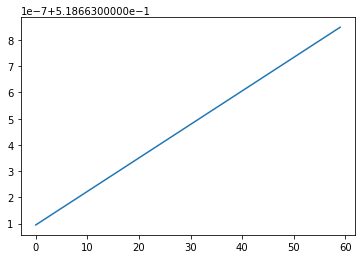

In [25]:
fig, ax = plt.subplots()
ax.plot(range(epochs), losses);

In [26]:
res = []
for x in x_test:
    y = classify(class_idx_to_name, layer_sizes, activation, final_act, weights, x)
    res.append(y)
    
with open(output_file, 'w') as f:
    print('\n'.join(res))
    f.write('\n'.join(res))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
